# Clasificación de imágenes usando CNN

Tarea # 5 Procesamiento Avanzado de Imágenes.

Nombre: José Rubio

## 1) Datasets

Cargando los datos CIFAR-10

In [2]:
!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-12-17 00:21:25--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  46.9MB/s    in 3.8s    

2020-12-17 00:21:29 (42.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [3]:
!tar -xvzf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [4]:
import torch
import numpy as np
import torch.nn as nn 
import torch.nn.functional as F
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import pickle
import itertools
import time

In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
from torch.utils.data import Dataset

class CIFAR10Train(Dataset):
  def __init__(self, path, scale=True):
    # Constructor, debe leer el archivo data_batch_1 dentro de la carpeta
    # indicada (este archivo se usará para el set de entrenamiento)
    self.data_batch_1 = unpickle(path + '/data_batch_1')
    self.scale = scale


  def __len__(self):
    # Debe retornar el número de imágenes en el dataset de entrenamiento
    return len(self.data_batch_1[b'data'])

  def __getitem__(self, index):
    # Debe retornar un par label, image
    # Donde label es una etiqueta, e image es un arreglo de 3x32x32
    # index es un número (o lista de números) que indica cuáles imágenes
    # y labels se deben retornar
    labels = []
    images = []
    try:
      for i in index:
        label = self.data_batch_1[b'labels'][i]
        if self.scale:
          image = 2*(np.array(self.data_batch_1[b'data'][i]))/255 - 1 # Al obtener los datos, tambien se aplica un escalamiento lineal.
        else:
          image = np.array(self.data_batch_1[b'data'][i])
        image = image.reshape(3, 32, 32)
        labels.append(label)
        images.append(image)
    except:
      labels = self.data_batch_1[b'labels'][index]
      if self.scale:
        image = 2*(np.array(self.data_batch_1[b'data'][index]))/255 - 1 # Se aplica el mismo escalamiento.
      else:
        image = np.array(self.data_batch_1[b'data'][index])
      images = image.reshape(3, 32, 32)

    return labels, images

In [7]:
class CIFAR10Val(Dataset):
  def __init__(self, path, scale=True):
    # Constructor, debe leer el archivo data_batch_1 dentro de la carpeta
    # indicada (este archivo se usará para el set de entrenamiento)
    self.data_batch_2 = unpickle(path + '/data_batch_2')
    self.scale = scale


  def __len__(self):
    # Debe retornar el número de imágenes en el dataset de entrenamiento
    return len(self.data_batch_2[b'data'])

  def __getitem__(self, index):
    # Debe retornar un par label, image
    # Donde label es una etiqueta, e image es un arreglo de 3x32x32
    # index es un número (o lista de números) que indica cuáles imágenes
    # y labels se deben retornar
    labels = []
    images = []
    try:
      for i in index:
        label = self.data_batch_2[b'labels'][i]
        if self.scale:
          image = 2*(np.array(self.data_batch_2[b'data'][i]))/255 - 1 # Al obtener los datos, tambien se aplica un escalamiento lineal.
        else:
          image = np.array(self.data_batch_2[b'data'][i])
        image = image.reshape(3, 32, 32)
        labels.append(label)
        images.append(image)
    except:
      labels = self.data_batch_2[b'labels'][index]
      if self.scale:
        image = 2*(np.array(self.data_batch_2[b'data'][index]))/255 - 1 # Se aplica el mismo escalamiento.
      else:
        image =  np.array(self.data_batch_2[b'data'][index])
      images = image.reshape(3, 32, 32)

    return labels, images

In [8]:
class CIFAR10Test(Dataset):
  def __init__(self, path, scale=True):
    # Constructor, debe leer el archivo data_batch_1 dentro de la carpeta
    # indicada (este archivo se usará para el set de entrenamiento)
    self.data_batch_t = unpickle(path + '/test_batch')
    self.scale = scale

  def __len__(self):
    # Debe retornar el número de imágenes en el dataset de entrenamiento
    return len(self.data_batch_t[b'data'])

  def __getitem__(self, index):
    # Debe retornar un par label, image
    # Donde label es una etiqueta, e image es un arreglo de 3x32x32
    # index es un número (o lista de números) que indica cuáles imágenes
    # y labels se deben retornar
    labels = []
    images = []
    try:
      for i in index:
        label = self.data_batch_t[b'labels'][i]
        if self.scale:
          image = 2*(np.array(self.data_batch_t[b'data'][i]))/255 - 1 # Al obtener los datos, tambien se aplica un escalamiento lineal.
        else:
          image = np.array(self.data_batch_t[b'data'][i])
        image = image.reshape(3, 32, 32)
        labels.append(label)
        images.append(image)
    except:
      labels = self.data_batch_t[b'labels'][index]
      if self.scale:
        image = 2*(np.array(self.data_batch_t[b'data'][index]))/255 - 1 # Se aplica el mismo escalamiento.
      else:
        image =  np.array(self.data_batch_t[b'data'][index])
      images = image.reshape(3, 32, 32)

    return labels, images

##2) CNN 

###Arquitectura Grande

In [9]:
class MyNetBig(nn.Module):
  def __init__(self, nclasses):
    super(MyNetBig, self).__init__()

    # Inicializadores de las capas necesarias para la arquitectura grande.

    self.nclasses = nclasses
    self.conv1 = nn.Conv2d(3, 64, (3, 3), stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
    self.conv4 = nn.Conv2d(128, 128, (3, 3), stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, (3, 3), stride=1, padding=1)
    self.conv6 = nn.Conv2d(256, 256, (3, 3), stride=1, padding=1)
    self.conv7 = nn.Conv2d(256, 512, (3, 3), stride=1, padding=1)
    self.conv8 = nn.Conv2d(512, 512, (3, 3), stride=1, padding=1)
    self.MaxPool = nn.MaxPool2d((3, 3), stride=2, padding=1)
    self.BN1 = nn.BatchNorm2d(64)
    self.BN2 = nn.BatchNorm2d(128)
    self.BN3 = nn.BatchNorm2d(256)
    self.BN4 = nn.BatchNorm2d(512)
    self.BN1d1 = nn.BatchNorm1d(128)
    self.BN1d2 = nn.BatchNorm1d(256)
    self.BN1d3 = nn.BatchNorm1d(512)
    self.BN1d4 = nn.BatchNorm1d(1024)
    self.flatten = nn.Flatten(1, 3)
    self.fc_1 = nn.Linear(2048, 128)
    self.fc_2 = nn.Linear(128, 256)
    self.fc_3 = nn.Linear(256, 512)
    self.fc_4 = nn.Linear(512, 1024)
    self.fc_out = nn.Linear(1024, nclasses)

  # Pasada hacia adelante.

  def forward(self, x):
    x = self.BN1(F.relu(self.conv1(x)))
    x = self.BN1(F.relu(self.conv2(x)))
    x = self.MaxPool(x)
    x = self.BN2(F.relu(self.conv3(x)))
    x = self.BN2(F.relu(self.conv4(x)))
    x = self.MaxPool(x)
    x = self.BN3(F.relu(self.conv5(x)))
    x = self.BN3(F.relu(self.conv6(x)))
    x = self.MaxPool(x)
    x = self.BN4(F.relu(self.conv7(x)))
    x = self.BN4(F.relu(self.conv8(x)))
    x = self.MaxPool(x)
    x = self.flatten(x)
    x = self.BN1d1(F.relu(self.fc_1(x)))
    x = self.BN1d2(F.relu(self.fc_2(x)))
    x = self.BN1d3(F.relu(self.fc_3(x)))
    x = self.BN1d4(F.relu(self.fc_4(x)))
    x_out = self.fc_out(x)
    return x_out

In [10]:
device = 'cuda'
test_model = MyNetBig(10).to(device)
summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,928
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]         590,080
      BatchNorm2d-14            [-1, 25

### Arquitectura Pequeña

In [11]:
class MyNetSmall(nn.Module):
  def __init__(self, nclasses):
    super(MyNetSmall, self).__init__()

    # Inicializadores de las capas necesarias para la arquitectura grande.

    self.nclasses = nclasses
    self.conv1 = nn.Conv2d(3, 64, (3, 3), stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, (3, 3), stride=1, padding=1)
    self.conv7 = nn.Conv2d(256, 512, (3, 3), stride=1, padding=1)
    self.MaxPool = nn.MaxPool2d((3, 3), stride=2, padding=1)
    self.BN1 = nn.BatchNorm2d(64)
    self.BN2 = nn.BatchNorm2d(128)
    self.BN3 = nn.BatchNorm2d(256)
    self.BN4 = nn.BatchNorm2d(512)
    self.BN1d1 = nn.BatchNorm1d(128)
    self.flatten = nn.Flatten(1, 3)
    self.fc_1 = nn.Linear(2048, 128)
    self.fc_out = nn.Linear(128, nclasses)

  # Pasada hacia adelante.

  def forward(self, x):
    x = self.BN1(F.relu(self.conv1(x)))
    x = self.MaxPool(x)
    x = self.BN2(F.relu(self.conv3(x)))
    x = self.MaxPool(x)
    x = self.BN3(F.relu(self.conv5(x)))
    x = self.MaxPool(x)
    x = self.BN4(F.relu(self.conv7(x)))
    x = self.MaxPool(x)
    x = self.flatten(x)
    x = self.BN1d1(F.relu(self.fc_1(x)))
    x_out = self.fc_out(x)
    return x_out

In [12]:
device = 'cuda'
test_model = MyNetSmall(10).to(device)
summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        MaxPool2d-12            [-1, 512, 2, 2]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

## 3) Entrenamiento de las redes

Configurando los datasets mediante Dataloader

In [27]:
from torch.utils.data import DataLoader, random_split

# Para poder reportar
import sys

dataset_train = CIFAR10Train('cifar-10-batches-py', scale=False)
dataset_val = CIFAR10Val('cifar-10-batches-py', scale=False)
dataset_test = CIFAR10Test('cifar-10-batches-py',scale=False)

batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

total_train = train_loader.dataset.__len__()
total_val = val_loader.dataset.__len__()

Programando el entrenamiento, mas una visualización para mostrar el desempeño de la red.

In [28]:
# Selccionando y configurando la red 

net = MyNetBig(10) 
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
epochs = 20

train_acc, val_acc, train_loss, val_loss = [], [], [], []
train_time, valid_time = [], []

for epoch in range(epochs):
  t_i = time.time()
  # El entrenamiento de los parametros se realizaran mediante .train()
  net.train()

  # Inicializando el valor para las métricas.
  running_loss, running_acc = 0.0, 0.0

  for i, data in enumerate(train_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    items = (i+1) * batch_size
    running_loss += loss.item()

    Y_pred = F.softmax(outputs, dim=1)
    max_prob, max_idx = torch.max(Y_pred, dim=1)
    running_acc += torch.sum(max_idx == labels).item()
    info = f'\rEpoch:{epoch+1}({items}/{total_train}), '
    info += f'Loss:{running_loss/(i+1):02.5f}, '
    info += f'Train Acc:{running_acc/items*100:02.1f}%'
    sys.stdout.write(info)

  train_acc.append(running_acc)
  train_loss.append(running_loss)
  t_f = time.time()
  epoch_train_time = round(t_f - t_i, 2) 
  # net.eval()
  tv_i = time.time()
  with torch.no_grad():
    running_acc = 0.0
    preds = np.zeros(10)
    targets = np.array([])
    for i, data in enumerate(val_loader, 0):
      labels = data[0].cuda()
      inputs = data[1].float().cuda()
      Y_pred = net(inputs)
      preds = np.vstack([preds, Y_pred.cpu().numpy()], )
      targets = np.append(targets, labels.cpu().numpy())
      Y_pred = F.softmax(Y_pred, dim=1)
      max_prob, max_idx = torch.max(Y_pred, dim=1)
      running_acc += torch.sum(max_idx == labels).item()
    info = f', Val Acc:{running_acc/total_val*100:02.2f}%.\n'
    sys.stdout.write(info)
    preds = torch.tensor(np.delete(preds, 0, 0))
    targets = torch.tensor(targets)
    val_loss_epoch = criterion(preds, targets.type(torch.LongTensor))
    val_loss.append(val_loss_epoch)
    val_acc.append(running_acc)
    tv_f = time.time()
    epoch_valid_time = round(tv_f - tv_i, 2)
  train_time.append(epoch_train_time)
  valid_time.append(epoch_valid_time)
  print('Epoch train time: ', epoch_train_time, '[s], Valid time: ', round(epoch_valid_time, 2), '[s]')

train_total = np.sum(np.array(train_time))
valid_total = np.sum(np.array(valid_time))
print('Train Total time: ', train_total, '[s], Valid Total time: ', valid_total, '[s]')

Epoch:1(10016/10000), Loss:2.07179, Train Acc:26.0%, Val Acc:29.74%.
Epoch train time:  5.96 [s], Valid time:  2.03 [s]
Epoch:2(10016/10000), Loss:1.74403, Train Acc:35.6%, Val Acc:40.46%.
Epoch train time:  5.9 [s], Valid time:  2.07 [s]
Epoch:3(10016/10000), Loss:1.51150, Train Acc:45.3%, Val Acc:45.92%.
Epoch train time:  5.94 [s], Valid time:  2.04 [s]
Epoch:4(10016/10000), Loss:1.36573, Train Acc:51.8%, Val Acc:51.36%.
Epoch train time:  5.87 [s], Valid time:  2.03 [s]
Epoch:5(10016/10000), Loss:1.23153, Train Acc:56.3%, Val Acc:57.52%.
Epoch train time:  5.84 [s], Valid time:  2.0 [s]
Epoch:6(10016/10000), Loss:1.11733, Train Acc:61.2%, Val Acc:58.83%.
Epoch train time:  5.81 [s], Valid time:  1.99 [s]
Epoch:7(10016/10000), Loss:0.98619, Train Acc:64.8%, Val Acc:62.82%.
Epoch train time:  5.78 [s], Valid time:  2.01 [s]
Epoch:8(10016/10000), Loss:0.88872, Train Acc:69.3%, Val Acc:63.02%.
Epoch train time:  5.77 [s], Valid time:  1.98 [s]
Epoch:9(10016/10000), Loss:0.80803, Train 

In [39]:
# Selccionando y configurando la red 

net_s = MyNetSmall(10) 
net_s.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_s.parameters(), lr=1e-3)
epochs = 20

train_acc_small, val_acc_small, train_loss_small, val_loss_small = [], [], [], []
train_time_small, valid_time_small = [], []

for epoch in range(epochs):
  t_i = time.time()
  # El entrenamiento de los parametros se realizaran mediante .train()
  net_s.train()

  # Inicializando el valor para las métricas.
  running_loss, running_acc = 0.0, 0.0

  for i, data in enumerate(train_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    optimizer.zero_grad()
    outputs = net_s(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    items = (i+1) * batch_size
    running_loss += loss.item()

    Y_pred = F.softmax(outputs, dim=1)
    max_prob, max_idx = torch.max(Y_pred, dim=1)
    running_acc += torch.sum(max_idx == labels).item()
    info = f'\rEpoch:{epoch+1}({items}/{total_train}), '
    info += f'Loss:{running_loss/(i+1):02.5f}, '
    info += f'Train Acc:{running_acc/items*100:02.1f}%'
    sys.stdout.write(info)

  train_acc_small.append(running_acc)
  train_loss_small.append(running_loss)
  t_f = time.time()
  epoch_train_time = round(t_f - t_i, 2)
  # net.eval()
  tv_i = time.time()
  with torch.no_grad():
    running_acc = 0.0
    preds = np.zeros(10)
    targets = np.array([])
    for i, data in enumerate(val_loader, 0):
      labels = data[0].cuda()
      inputs = data[1].float().cuda()
      Y_pred = net_s(inputs)
      preds = np.vstack([preds, Y_pred.cpu().numpy()])
      targets = np.append(targets, labels.cpu().numpy())
      Y_pred = F.softmax(Y_pred, dim=1)
      max_prob, max_idx = torch.max(Y_pred, dim=1)
      running_acc += torch.sum(max_idx == labels).item()
    info = f', Val Acc:{running_acc/total_val*100:02.2f}%.\n'
    sys.stdout.write(info)
    preds = torch.tensor(np.delete(preds, 0, 0))
    targets = torch.tensor(targets)
    val_loss_epoch = criterion(preds, targets.type(torch.LongTensor))
    val_loss_small.append(val_loss_epoch) 
    val_acc_small.append(running_acc)
    tv_f = time.time()
    epoch_valid_time = round(tv_f - tv_i, 2)
  train_time_small.append(epoch_train_time)
  valid_time_small.append(epoch_valid_time)
  print('Epoch train time: ', epoch_train_time, '[s], Valid time: ', epoch_valid_time, '[s]')

train_total = np.round(np.sum(np.array(train_time_small)), 2)
valid_total = np.round(np.sum(np.array(valid_time_small)), 2)
print('Train Total time: ', train_total, '[s], Valid Total time: ', valid_total, '[s]')

Epoch:1(10016/10000), Loss:1.58932, Train Acc:42.1%, Val Acc:50.20%.
Epoch train time:  3.15 [s], Valid time:  1.31 [s]
Epoch:2(10016/10000), Loss:1.22160, Train Acc:56.1%, Val Acc:57.22%.
Epoch train time:  3.01 [s], Valid time:  1.34 [s]
Epoch:3(10016/10000), Loss:1.05234, Train Acc:62.5%, Val Acc:63.46%.
Epoch train time:  2.99 [s], Valid time:  1.34 [s]
Epoch:4(10016/10000), Loss:0.94943, Train Acc:66.3%, Val Acc:64.06%.
Epoch train time:  3.01 [s], Valid time:  1.33 [s]
Epoch:5(10016/10000), Loss:0.82536, Train Acc:70.9%, Val Acc:65.10%.
Epoch train time:  3.03 [s], Valid time:  1.33 [s]
Epoch:6(10016/10000), Loss:0.67518, Train Acc:76.5%, Val Acc:66.69%.
Epoch train time:  3.01 [s], Valid time:  1.32 [s]
Epoch:7(10016/10000), Loss:0.53692, Train Acc:81.4%, Val Acc:67.77%.
Epoch train time:  3.01 [s], Valid time:  1.32 [s]
Epoch:8(10016/10000), Loss:0.44919, Train Acc:84.4%, Val Acc:69.44%.
Epoch train time:  3.02 [s], Valid time:  1.32 [s]
Epoch:9(10016/10000), Loss:0.32042, Trai

## 4) Evaluación de las redes

### Gráfico de rendimientos y matrices de confusión

In [30]:
import matplotlib.pyplot as plt

#### Red Grande

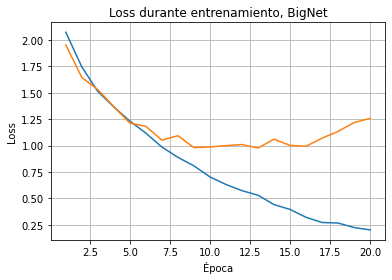

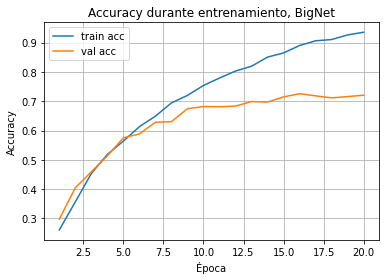

In [31]:
Epochs = range(1, epochs+1)

plt.plot(Epochs, np.array(train_loss)/313, label='train loss')
plt.plot(Epochs, val_loss, label='val loss')
plt.title('Loss durante entrenamiento, BigNet')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
# plt.savefig('Big_loss.png')
plt.show()

plt.plot(Epochs, np.array(train_acc)/10000, label='train acc')
plt.plot(Epochs, np.array(val_acc)/10000, label='val acc')
plt.title('Accuracy durante entrenamiento, BigNet')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
# plt.savefig('Big_accuracy.png')
plt.show()

#### Matriz de confusión

Código para generar la matriz de confusión de una red

In [32]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues, fig_size=(7,7)):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=fig_size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [33]:
net.cuda()

preds_big, targets = np.array([]), np.array([])

with torch.no_grad():
  running_acc = 0.0
  for i, data in enumerate(val_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    Y_pred = net(inputs)
    Y_pred = F.softmax(Y_pred, dim=1)
    max_prob, max_idx = torch.max(Y_pred, dim=1)
    preds_big = np.append(preds_big, max_idx.cpu().numpy())
    targets = np.append(targets, labels.cpu().numpy())
    running_acc += torch.sum(max_idx == labels).item()
  info = f'Test Accuracy: {running_acc/total_val*100:02.2f}%.\n'
  sys.stdout.write(info)

Test Accuracy: 71.51%.


Normalized confusion matrix


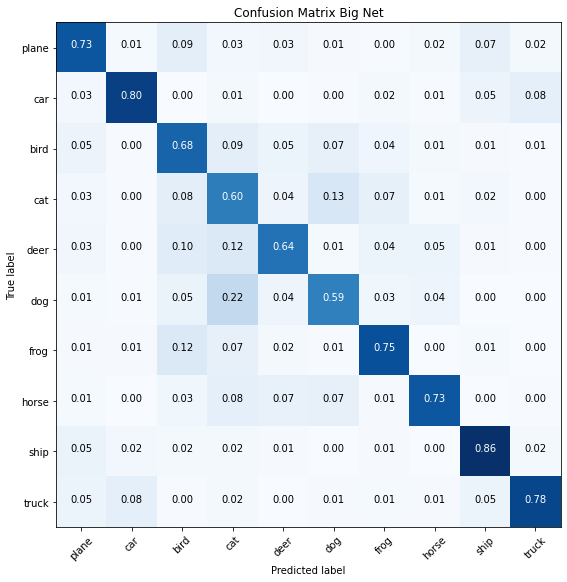

In [34]:
cm_big = confusion_matrix(targets, preds_big)

plot_confusion_matrix(cm_big, classes, title='Confusion Matrix Big Net' ,fig_size=(8,8))
# plt.savefig('CM_BigNet.png')

#### Red Pequeña

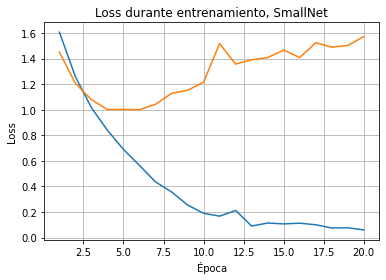

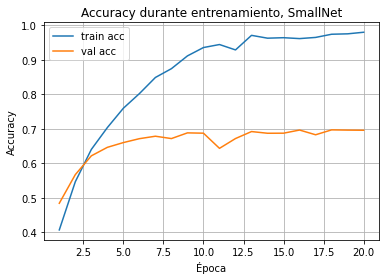

In [35]:
plt.plot(Epochs, np.array(train_loss_small)/313, label='train loss')
plt.plot(Epochs, val_loss_small, label='val loss')
plt.title('Loss durante entrenamiento, SmallNet')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
# plt.savefig('Small_loss.png')
plt.show()

plt.plot(Epochs, np.array(train_acc_small)/10000, label='train acc')
plt.plot(Epochs, np.array(val_acc_small)/10000, label='val acc')
plt.title('Accuracy durante entrenamiento, SmallNet')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
# plt.savefig('Small_accuracy.png')
plt.show()

Evaluación en el conjunto de prueba y creación de matrices de confusión.

In [36]:
net_s.cuda()

preds_small, targets = np.array([]), np.array([])

with torch.no_grad():
  running_acc = 0.0
  for i, data in enumerate(val_loader, 0):
    labels = data[0].cuda()
    inputs = data[1].float().cuda()
    Y_pred = net_s(inputs)
    Y_pred = F.softmax(Y_pred, dim=1)
    max_prob, max_idx = torch.max(Y_pred, dim=1)
    preds_small = np.append(preds_small, max_idx.cpu().numpy())
    targets = np.append(targets, labels.cpu().numpy())
    # print(max_idx.size())
    running_acc += torch.sum(max_idx == labels).item()
  info = f'Test Accuracy: {running_acc/total_val*100:02.2f}%.\n'
  sys.stdout.write(info)

Test Accuracy: 69.45%.


In [37]:
cm_small = confusion_matrix(targets, preds_small)

Normalized confusion matrix


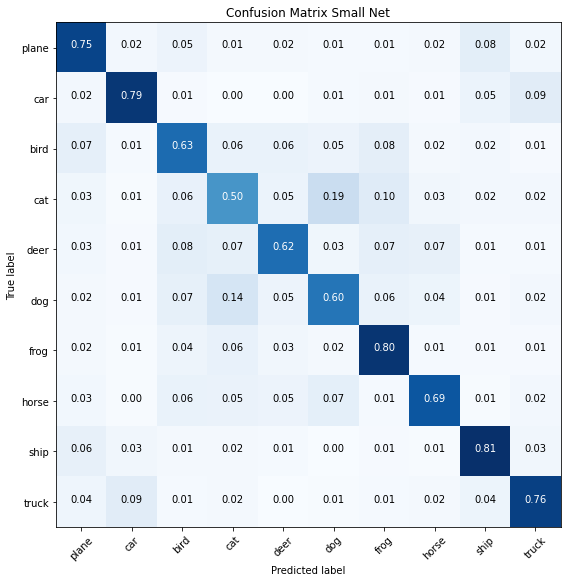

In [38]:
plot_confusion_matrix(cm_small, classes, title='Confusion Matrix Small Net', fig_size=(8,8))
plt.savefig('CM_SmallNet.png')